In [2]:
import pandas as pd
import numpy as np
import gpflow
import matplotlib.pyplot as plt
import pickle

import utils as u
from models import Poisson_Model_T
%matplotlib inline


%load_ext autoreload
%autoreload 2

/home/ecbm4040/miniconda2/envs/dlenv/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [4]:
data = pd.read_csv('../data/gp_weekly_grid_parkslope.csv')
data['DATETIME'] = pd.to_datetime(data['DATETIME'])
e_s = (5.36 / data.GRID_SQUARE.max()) # 5.36 is 2016 mean weekly crashes in park slope, divide by # squares
print(e_s)

0.111666666667


In [5]:
start_date = ['2017-01-01','2017-02-05','2017-03-05']

gpflow.priors.LogNormal

gpflow.priors.LogNormal

Beginning run 2017-01-01 : 
Training ends on: 2017-03-26 00:00:00
testing ends on: 2017-06-18 00:00:00
Initial neg. log-likelihood: -1252.95232894
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 515.884646
  Number of iterations: 336
  Number of functions evaluations: 362
added gp pred and error to test
gp_sq_error    0.717110
0              0.842949
dtype: float64
Beginning run 2017-02-05 : 
Training ends on: 2017-04-30 00:00:00
testing ends on: 2017-07-23 00:00:00
Initial neg. log-likelihood: -1416.39316186
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 552.609615
  Number of iterations: 818
  Number of functions evaluations: 865
added gp pred and error to test
gp_sq_error    0.693482
0              0.810897
dtype: float64
Beginning run 2017-03-05 : 
Training ends on: 2017-05-28 00:00:00
testing ends on: 2017-

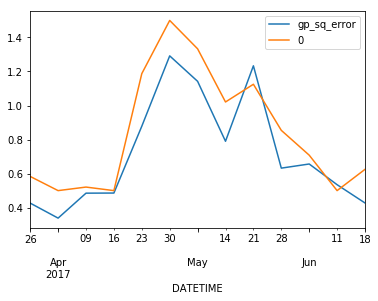

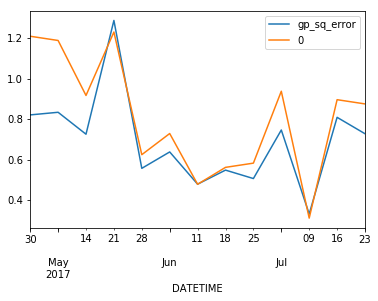

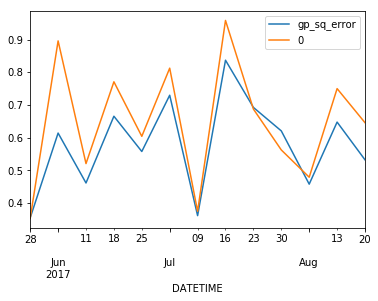

In [10]:
for i, s in enumerate(start_date):
    
    
    
    print('Beginning run {} : '.format(str(s)))
    #print('{} periods for training \n').format(s[0])
    #print('{} periods for testing \n').format(s[1])

    data_dict = u.preprocess(data, start_date= s, training_end_date= 12, \
                                                           testing_end_date=12)

    m = Poisson_Model_T(data_dict['X_train'],data_dict['y_train'],use_priors=True, e_s= e_s, period = 52)
    m.compile()
    opt = gpflow.train.ScipyOptimizer()
    print('Initial neg. log-likelihood: {}'.format(str(m.compute_log_likelihood())))
    opt.minimize(m, maxiter = 1000)
    
    u.pred_GP(m,data_dict)
    
    test = data_dict['test']

    gp = test.groupby('DATETIME')['gp_sq_error'].mean() #/ test.GRID_SQUARE.max()
    ar = u.run_AR(data_dict)
    summary = pd.concat([gp,ar],axis=1)
    summary.plot()

    print(summary.mean())


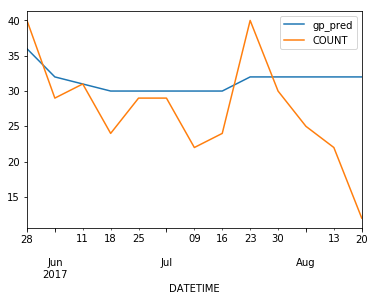

In [11]:
test.groupby('DATETIME')[['gp_pred','COUNT']].sum().plot()

In [12]:
test.groupby('GRID_SQUARE')['COUNT'].sum().sort_values(ascending = False).head()

GRID_SQUARE
33.0    52.0
44.0    27.0
35.0    17.0
5.0     16.0
34.0    16.0
Name: COUNT, dtype: float64

In [13]:
test[test.GRID_SQUARE == 33][['gp_pred','COUNT']]

,gp_pred,COUNT
DATETIME,,
2017-05-28,4.0,5.0
2017-06-04,4.0,3.0
2017-06-11,4.0,5.0
2017-06-18,4.0,2.0
2017-06-25,4.0,5.0
2017-07-02,4.0,3.0
2017-07-09,4.0,3.0
2017-07-16,4.0,3.0
2017-07-23,5.0,5.0
